# Phase 4: Interpretation & Simulation

**Goal**: Interpret the driving forces behind the behavioral clusters using the best performing model (XGBoost).
**Model**: XGBoost (Accuracy 47%, F1 0.33)
**Method**: SHAP (SHapley Additive exPlanations) - TreeExplainer
**Data**: `final_dataset_18parks.csv` (Singleton filtered)

In [1]:
import pandas as pd
import numpy as np
import shap
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

shap.initjs()
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. Train Final Model

In [2]:
# Load Data (with same filtering)
df = pd.read_csv('../interim/final_dataset_18parks.csv')

# Filter Singleton (Cluster 3)
counts = df['cluster'].value_counts()
to_keep = counts[counts > 1].index
df = df[df['cluster'].isin(to_keep)].copy()

X = df.drop(columns=['park_name', 'cluster'])
y = df['cluster']

# Encoding
le = LabelEncoder()
y = le.fit_transform(y)
# X does not STRICTLY need scaling for XGB, but good practice if already done. 
# For visual interpretation, unscaled X is often better to see real units.

# Train XGBoost on ALL Data
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_estimators=50, max_depth=3)
model.fit(X, y)
print("Final XGBoost Model Trained.")

Final XGBoost Model Trained.


c:\Users\jour\anaconda3\envs\yj_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:37:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 2. SHAP Analysis (Tree Explainer)
XGBoost allows using the fast TreeExplainer.

In [3]:
# Initialize Explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP Values
shap_values = explainer.shap_values(X)
print("SHAP Values Calculated.")

SHAP Values Calculated.


## 3. Visualization
We visualize the global importance and class-specific drivers.

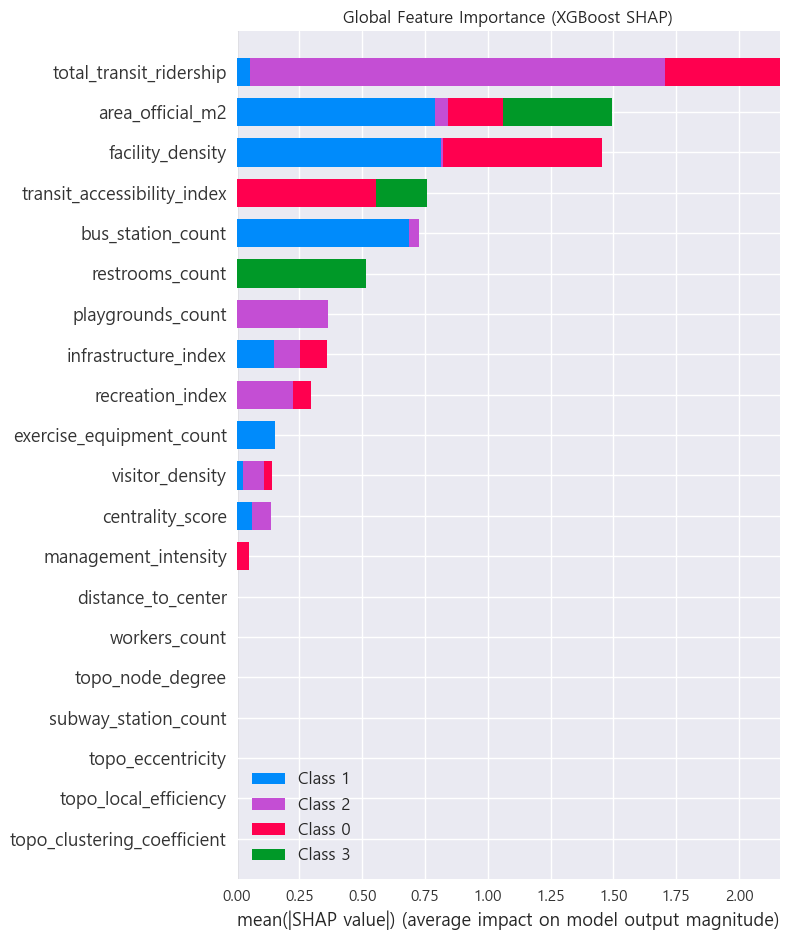

In [4]:
# Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title("Global Feature Importance (XGBoost SHAP)")
plt.tight_layout()
plt.savefig('../results/phase4_shap_summary_bar.png')
plt.show()

<Figure size 1000x600 with 0 Axes>

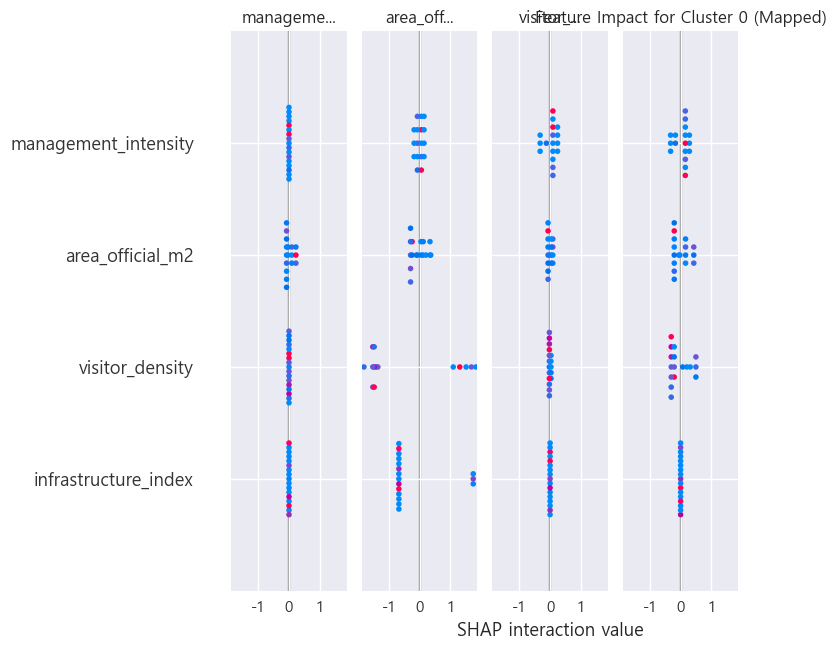

<Figure size 1000x600 with 0 Axes>

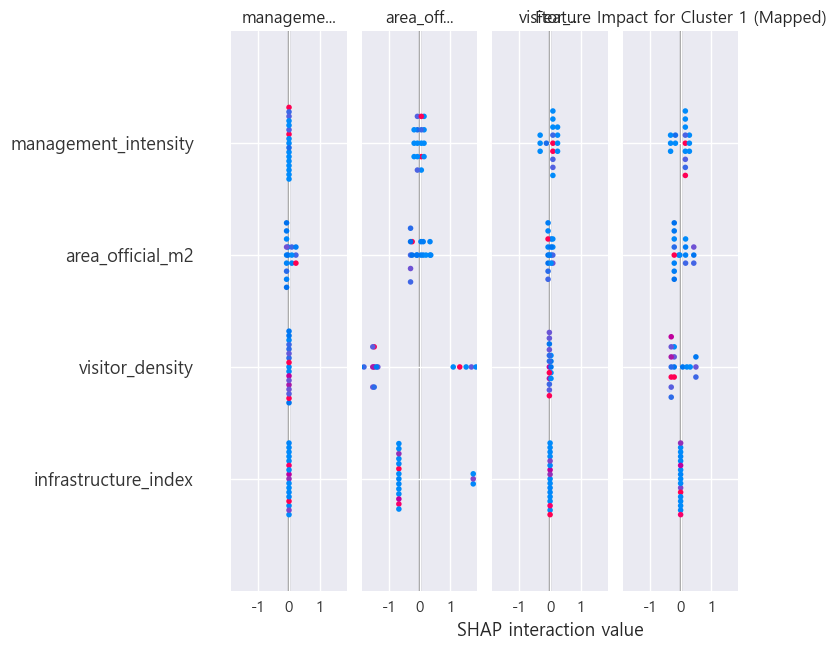

<Figure size 1000x600 with 0 Axes>

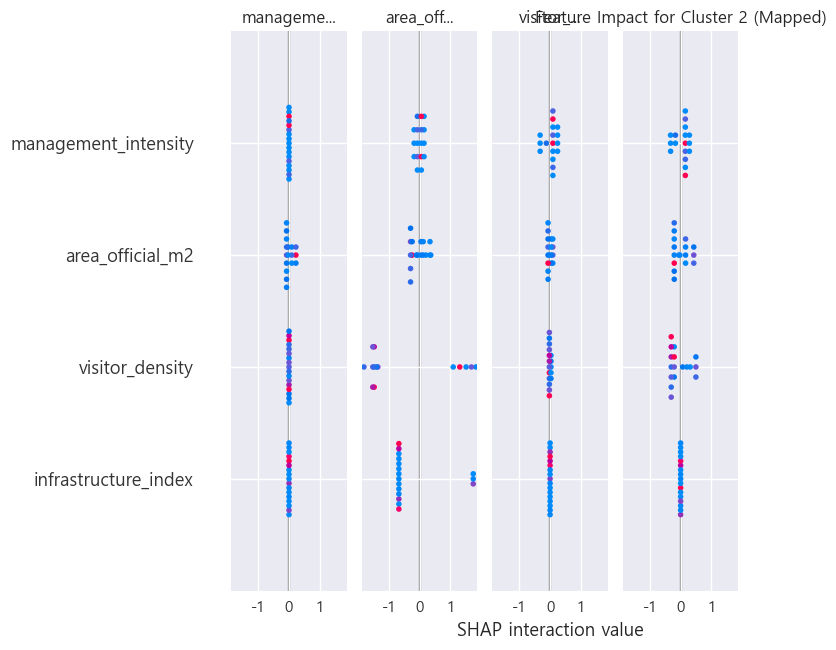

<Figure size 1000x600 with 0 Axes>

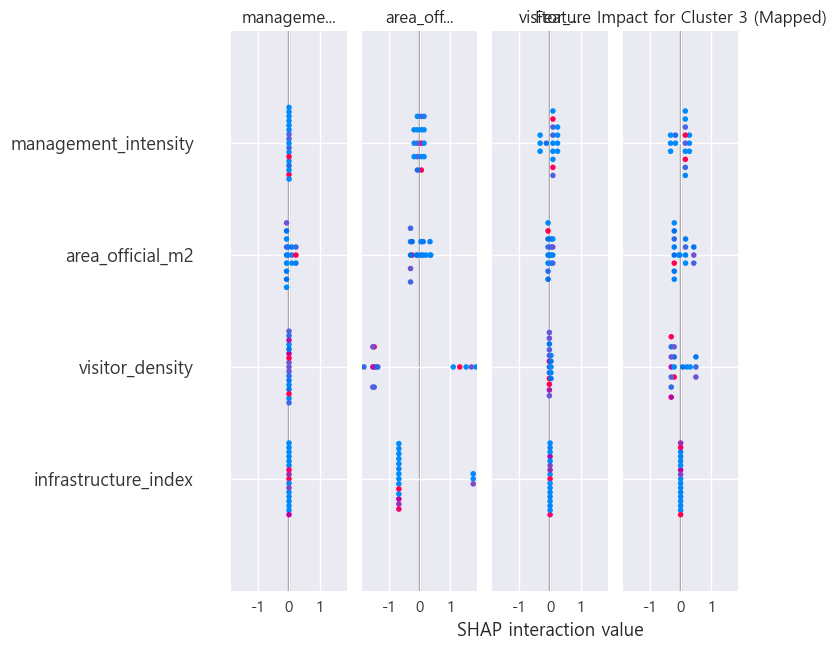

In [5]:
# Beeswarm Plot (for a specific class, e.g., Cluster 0)
n_classes = len(np.unique(y))
for i in range(n_classes):
    plt.figure(figsize=(10, 6))
    # Check shape of shap_values. For multi-class XGBoost, it is list of arrays OR array (samples, features, classes) depending on version.
    # Usually list. 
    vals = shap_values[i] if isinstance(shap_values, list) else shap_values
    
    shap.summary_plot(vals, X, show=False)
    plt.title(f"Feature Impact for Cluster {i} (Mapped)")
    plt.tight_layout()
    plt.savefig(f'../results/phase4_shap_beeswarm_cluster{i}.png')
    plt.show()

## 4. Scenario Simulation
Simulate the effect of increasing `transit_accessibility_index` on Cluster interpretation.

In [6]:
# Baseline Prediction for 'Dream Forest' (Example)
target_park = 'Dream Forest'
if target_park in df['park_name'].values:
    idx = df[df['park_name'] == target_park].index[0]
    baseline_input = X.iloc[[idx]].copy()
    base_pred = model.predict(baseline_input)[0]
    base_prob = model.predict_proba(baseline_input)[0]
    print(f"Baseline {target_park}: Cluster {base_pred}, Probs: {base_prob}")

    # Simulation: Increase Subway Stations
    simulated_input = baseline_input.copy()
    if 'subway_station_count' in simulated_input.columns:
        # Increase by 2 (units, since unscaled)
        simulated_input['subway_station_count'] += 2 
        sim_pred = model.predict(simulated_input)[0]
        sim_prob = model.predict_proba(simulated_input)[0]
        print(f"Simulated {target_park} (+Subway): Cluster {sim_pred}, Probs: {sim_prob}")

Baseline Dream Forest: Cluster 0, Probs: [0.89556533 0.05441537 0.02477143 0.02524785]
Simulated Dream Forest (+Subway): Cluster 0, Probs: [0.89556533 0.05441537 0.02477143 0.02524785]
